# Navigation Project Report

### 1. Examination of State and Action Spaces

Environment has a large space where yellow and blue bananas are placed randomly. An agent has four action;

- 0: walk forward
- 1: walk backward
- 2: turn left
- 3: turn right

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana.

### 2. Agent

Agent is Double DQN (DDQN). In early stages of DQN training overestimation may occur due to noisy set of numbers at the beginning and we use argmax to select max value among noisy numbers. DDQN can avoid overestimation.

In [8]:
agent = Agent(state_size=STATE_SIZE, 
              action_size=ACTION_SIZE, 
              seed=SEED)

In [9]:
learner = learnerDQN(agent, state_size=STATE_SIZE, action_size=ACTION_SIZE,
                 seed=SEED, n_episodes=N_EPISODES, max_t=MAX_T,
                eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Initialized!


In [ ]:
learner.train()

Training!


### 3. Hyperparameters

Selected hyperparameters for this agent is given below.

 - hidden layers: 32 and 16 (spesifies architecture of NN)
 - tau: 0.001 (update rate)
 - learning rate: 0.0005 (used by Adam optimizer)

In [21]:
agent = Agent(state_size=state_size, 
              action_size=action_size, 
              seed=50,
              hidden_layers=[32, 16], 
              tau=1e-3, 
              learning_rate=5e-4)

In [22]:
# reset environment
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]

# run without training
for j in range(200):
    # select action
    action = agent.act(state).astype(int)
    env_info = env.step(action)[brain_name]
    
    # get the next state
    state = env_info.vector_observations[0]
    # get the reward
    reward = env_info.rewards[0]
    # see if episode has finished
    done = env_info.local_done[0]
    if done:
        break

### 4. Training

Training of the agent against to "Banana" environment has a termination rule if training process goes towards to increasing score: minimum score of 15.0.

To overcome of overestimation of DQN, DDQN uses parameters w to select the best action and parameters w' to evaluate that action.

Experience Replay is implemented to the algorithm. In this technique, DDQN model is trained by mini-batch from replay buffer.

Agent select next action based on Epsilon Greedy. At probability epsilon, agent select at random from action space. The value of epsilon is set 0.999, and decrease gradually with time until 0.001.

In [23]:
def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train Agent by playing simulator
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]   # get the next state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps).astype(int)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>= 15.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

In [24]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
scores = train()

Episode 100	Average Score: 0.67
Episode 200	Average Score: 4.00
Episode 300	Average Score: 7.22
Episode 400	Average Score: 10.28
Episode 500	Average Score: 12.84
Episode 600	Average Score: 13.81
Episode 649	Average Score: 15.00
Environment solved in 549 episodes!	Average Score: 15.00


### 5. Plots

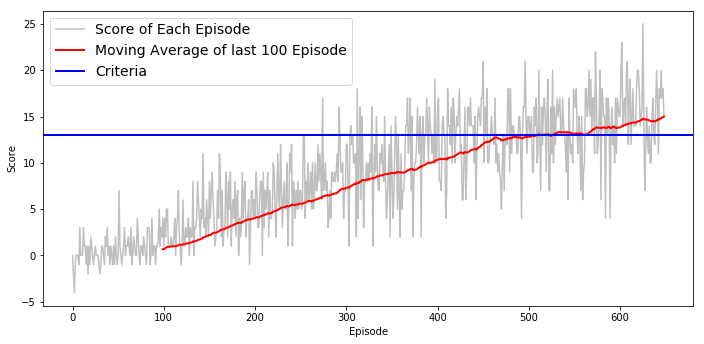

In [25]:
fig, ax = plt.subplots(1, 1, figsize=[10, 5])
plt.rcParams.update({'font.size': 14})

scores_avg = pd.Series(scores).rolling(100).mean()
ax.plot(scores, "-", c="black", alpha=0.25)
ax.plot(scores_avg, "-", c="red", linewidth=2)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.axhline(13, c="blue", linewidth=2)
ax.legend(["Score of Each Episode", "Moving Average of last 100 Episode", "Criteria"])

fig.tight_layout()

### 6. Restoring Results

In [26]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]   # get the next state
       
    for j in range(1000):
        action = agent.act(state).astype(int)
        env_info = env.step(action)[brain_name]
        reward = env_info.rewards[0] 
        state = env_info.vector_observations[0]   # get the next state
        done = env_info.local_done[0]                  # see if episode has finished
        if done:
            break

### 7. Future Work

There might more to do for better performing agent. They can be listed as two ideas as in below;

- Prioritized Experience Replay: it is used for to break consecutive experience to create unharmful correlations and stabilization of our learning. But there might be importnant events occur infrequently. A metric called TD error is used to understand how important is the given event tuple. According to importance we change that events' sampling probability.

- Dueling DQN: this architecture has a two data flow stream; one for state values V(s) and other for advantage values A(s,a). These two stream later is combined in the network so we calculate Q-values.

There is more than these two improvements. In total six improvement of mainstream DQN alternative is available. A network called "Rainbow" is combination of all of six and it knew for its outpermorfing performance.